### IBM Advanced Data Science Capstone Project

Revenue prediction using machine learning and deep learning models.

"Movie Industry" dataset found on kaggle: 
https://www.kaggle.com/danielgrijalvas/movies

The dependent variable is a binary class feature where "1" is a movie where gross is at least 2x the budget.

Initial analysis reveals that the data is neatly organized, can be saved as a .csv file and imported into IBM cloud with ease.

#### Extract, transform, load (ETL)

In [1]:
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
import seaborn as sns
import types
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import pathlib
from botocore.client import Config
import ibm_boto3
%matplotlib inline

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_b5c4006d1f5d4841aec63336ddecbc8b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='BZBOuKMKyCavla8OqaKiyHvaJF7uISoXbOXZNR_PAVd5',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_b5c4006d1f5d4841aec63336ddecbc8b.get_object(Bucket='advanced-donotdelete-pr-iiadgzegpf3nfx',Key='movies.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body, encoding='latin-1')
df.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


Converting "gross" and "budget" features from dollar to million dollar units:

In [2]:
df['budget'] = df['budget']/1000000
df['gross'] = df['gross']/1000000

#### Data exploration

In [3]:
df.describe()

,budget,gross,runtime,score,votes,year
count,6820.000000,6820.000000,6820.00000,6820.000000,6.820000e+03,6820.000000
mean,24.581129,33.497829,106.55132,6.374897,7.121952e+04,2001.000293
std,37.022536,58.197602,18.02818,1.003142,1.305176e+05,8.944501
min,0.000000,0.000070,50.00000,1.500000,2.700000e+01,1986.000000
25%,0.000000,1.515839,95.00000,5.800000,7.665250e+03,1993.000000
50%,11.000000,12.135679,102.00000,6.400000,2.589250e+04,2001.000000
75%,32.000000,40.065340,115.00000,7.100000,7.581225e+04,2009.000000
max,300.000000,936.662225,366.00000,9.300000,1.861666e+06,2016.000000


Budget of 0.0 anomaly detected

In [4]:
len(df[(df['budget'] == 0.0)])

2182

In [5]:
len(df[(df['budget'] != 0.0)])

4638

In [6]:
len(df[(df['gross'] == 0.0)])

0

In [7]:
len(df[(df['gross'] != 0.0)])

6820

About a third of the movies have a zero dollar budget. Taking a closer look: 

In [8]:
df[(df['budget'] == 0.0)].head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
25,0.0,TriStar Pictures,USA,John Badham,Comedy,40.697761,Short Circuit,PG,1986-05-09,98,6.6,Ally Sheedy,47068,S.S. Wilson,1986
26,0.0,Neue Constantin Film,Italy,Jean-Jacques Annaud,Crime,7.153487,The Name of the Rose,R,1986-09-24,130,7.8,Sean Connery,86991,Umberto Eco,1986
27,0.0,TriStar Pictures,USA,Sidney J. Furie,Action,24.159872,Iron Eagle,PG-13,1986-01-17,117,5.3,Louis Gossett Jr.,11304,Kevin Alyn Elders,1986
32,0.0,Gaumont,France,Jean-Jacques Beineix,Drama,2.003822,Betty Blue,Not specified,1986-11-07,120,7.4,Jean-Hugues Anglade,14562,Philippe Djian,1986
35,0.0,Columbia Pictures Corporation,USA,John G. Avildsen,Action,115.103979,The Karate Kid Part II,PG,1986-06-20,113,5.9,Pat Morita,58370,Robert Mark Kamen,1986


It is very unlikely that these movies had a budget of 0.0 million dollars. 
The error could be due to incomplete archives or user error when scraping data.
Will exclude these titles from the analysis.

In [4]:
df = df[(df['budget'] != 0.0)]

In [5]:
df.shape

(4638, 15)

In [11]:
df.dtypes

budget      float64
company      object
country      object
director     object
genre        object
gross       float64
name         object
rating       object
released     object
runtime       int64
score       float64
star         object
votes         int64
writer       object
year          int64
dtype: object

In [13]:
df.year = df.year.astype(str)

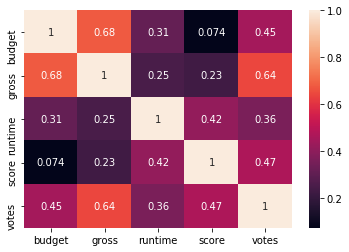

In [14]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

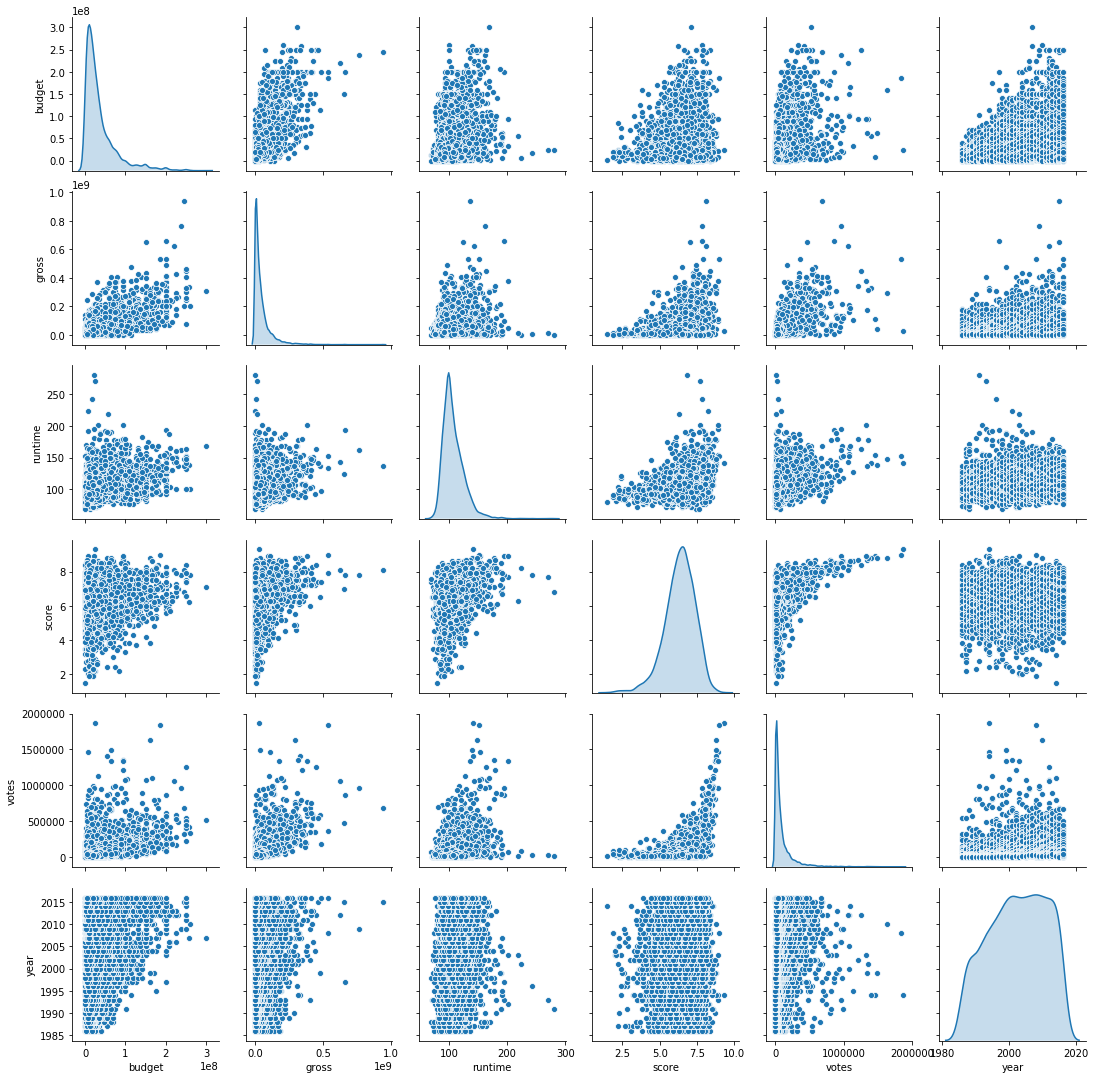

In [86]:
sns.pairplot(df, diag_kind='kde')

Descriptive statistics are not the focus of this project so no further exploratory analysis is conducted

#### Feature creation 

Creating a new binary feature for classification:

In [6]:
def f2(row):
    if row['gross'] == row['budget']:
        val = 0
    elif row['gross'] > row['budget']*2:
        val = 1
    else:
        val = 0
    return val

df['profitable'] = df.apply(f2, axis=1)

In [7]:
df['profitable'].unique()

array([1, 0])

In [8]:
df['profitable'].value_counts()

0    3491
1    1147
Name: profitable, dtype: int64

This feature turned out fairly balanced when using the original dataset.
However, by excluding the observations where budget equaled zero, I got rid of one problem and introduced another (class imbalance)

Even though it is possible to account for class imbalance internally within an ANN
and the decision tree / ensamble tree algorithms are (in many cases) able look past class imbalance,
I decided to go ahead and balance the classes using the imblearn’s SMOTE or Synthetic Minority Oversampling Technique. 
SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

In [9]:
# Encoding categorical variables and choosing features for analysis
# Very few features were selected, due to computational restrictions of the free IBM Cloud service, 
FeaturesToEncode = df[['genre']]
Features = df[['budget','profitable']]
df2 = pd.concat([Features, pd.get_dummies(FeaturesToEncode, drop_first=True)], axis=1) # "drop first" to avoid multicollinearity
X = df2.loc[:, df2.columns != 'profitable']
y = df2['profitable']

In [10]:
# splitting training feature and target sets into training and validation subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3710, 16) (3710,)
Test set: (928, 16) (928,)


For SMOTE: <br/>
Install imblearn through !pip install imblearn <br/>
Restart kernel

In [ ]:
# !pip install imblearn

In [11]:
# Run SMOTE or Synthetic Minority Oversampling Technique to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [12]:
# Transform (normalize) data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Verify class balance
y_train.value_counts()

1    2780
0    2780
Name: profitable, dtype: int64

In [14]:
# Verifying that the data is normalized
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.0
mean,0.119044,0.065733,0.043103,0.032328,0.298491,0.074353,0.186422,0.002155,0.008621,0.047414,0.001078,0.006466,0.002155,0.003233,0.001078,0.0
std,0.128474,0.247948,0.203199,0.176964,0.457843,0.262487,0.389657,0.046399,0.092496,0.212637,0.032827,0.080191,0.046399,0.056796,0.032827,0.0
min,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.033314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.076648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.166400,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,0.859997,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


#### KNN Classifier

Since the classes (labels) are unbalanced, we cannot use accuracy to access the performance of the classifier that we'll build. A classifier which always returns 0 will have an accuracy around 87% (assuming the given data is well sampled). Instead, we'll use the F1-score because it takes into account the precision and recall of the system, which should be the case here.

Finding optimal "k" (using F1 score):

In [40]:
from sklearn.neighbors import KNeighborsClassifier

Ks = 14
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.f1_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.32, 0.17, 0.28, 0.21, 0.24, 0.2 , 0.25, 0.2 , 0.23, 0.21, 0.29,
       0.25, 0.26])

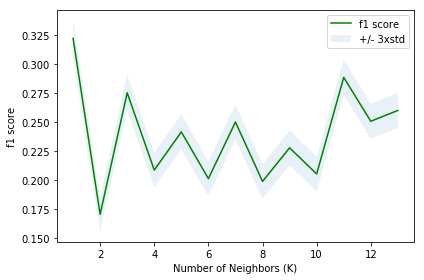

In [41]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('f1 score', '+/- 3xstd'))
plt.ylabel('f1 score')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [42]:
print( "The best f1 score was ", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best f1 score was  0.3221476510067114 with k= 1


Using k = 1:

In [43]:
k = 1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=1)

In [44]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 0, 0, 0, 0])

In [45]:
y_test.head()

4426    0
3357    0
4946    1
4610    0
2930    1
Name: profitable, dtype: int64

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0])) 

[[ 72 145]
 [158 553]]


Confusion matrix, without normalization
[[ 72 145]
 [158 553]]


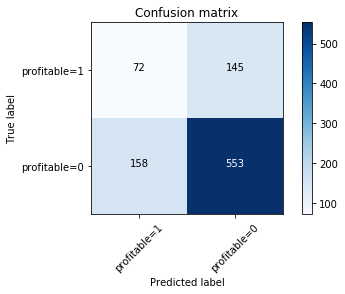

In [47]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['profitable=1','profitable=0'],normalize= False,  title='Confusion matrix')

In [48]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6872302158273381
Test set Accuracy:  0.6734913793103449


In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print(accuracy_score(y_test, yhat))
print(f1_score(y_test, yhat))
print(recall_score(y_test, yhat))

0.6734913793103449
0.3221476510067114
0.3317972350230415


#### Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [51]:
yhat = LR.predict(X_test)

In [52]:
yhat_prob = LR.predict_proba(X_test)

In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yhat)

0.6023706896551724

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0])) 

[[ 92 125]
 [244 467]]


Confusion matrix, without normalization
[[ 92 125]
 [244 467]]


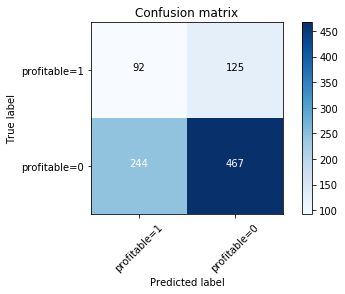

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['profitable=1','profitable=0'],normalize= False,  title='Confusion matrix')

In [56]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       711
           1       0.27      0.42      0.33       217

    accuracy                           0.60       928
   macro avg       0.53      0.54      0.52       928
weighted avg       0.67      0.60      0.63       928



In [57]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

print(accuracy_score(y_test, yhat))
print(f1_score(y_test, yhat))
print(recall_score(y_test, yhat))
print(log_loss(y_test, yhat_prob))

0.6023706896551724
0.33273056057866185
0.423963133640553
0.6858756178820123


#### Decision Tree classifier

Decision Tree is a non-linear classifier like the neural networks and is generally used for classifying non-linearly separable data. <br>

In [58]:
from sklearn.tree import DecisionTreeClassifier
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [59]:
predTree = Tree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

[0 0 1 1 0]
4426    0
3357    0
4946    1
4610    0
2930    1
Name: profitable, dtype: int64


In [63]:
print(accuracy_score(y_test, predTree))
print(f1_score(y_test, predTree))
print(recall_score(y_test, predTree))

0.6206896551724138
0.40740740740740733
0.5576036866359447


#### Gradient Boosting Trees classifier

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.631
Accuracy score (validation): 0.621
Learning rate:  0.075
Accuracy score (training): 0.631
Accuracy score (validation): 0.621
Learning rate:  0.1
Accuracy score (training): 0.631
Accuracy score (validation): 0.628
Learning rate:  0.25
Accuracy score (training): 0.641
Accuracy score (validation): 0.557
Learning rate:  0.5
Accuracy score (training): 0.650
Accuracy score (validation): 0.621
Learning rate:  0.75
Accuracy score (training): 0.648
Accuracy score (validation): 0.622
Learning rate:  1
Accuracy score (training): 0.651
Accuracy score (validation): 0.609


In [74]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[381 330]
 [ 81 136]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.54      0.65       711
           1       0.29      0.63      0.40       217

    accuracy                           0.56       928
   macro avg       0.56      0.58      0.52       928
weighted avg       0.70      0.56      0.59       928



In [75]:
from xgboost import XGBClassifier

In [76]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier()

In [77]:
XBoostTree = xgb_clf.predict(X_test)
print (XBoostTree [0:5])
print (y_test [0:5])

[0 1 1 0 1]
4426    0
3357    0
4946    1
4610    0
2930    1
Name: profitable, dtype: int64


In [78]:
print(accuracy_score(y_test, XBoostTree))
print(f1_score(y_test, XBoostTree))
print(recall_score(y_test, XBoostTree))

0.5905172413793104
0.3851132686084142
0.5483870967741935


#### Artificial Neural Network

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

Tuning the Number of Neurons in the Hidden Layers, Batch Size and Number of Epochs using GridSearchCV: <br>

The number of neurons is one of the most important hyperparameters to tune as it controls the representational capacity of the network.<br>
Although computationally intense, I chose to tune 3 parameters simultaneously. <br>
I believe that at least the batch size and number of epochs should (ideally) be optimized with the number of neurons and done at the very first step.

In [80]:
# Defining the initial structure
def create_model(neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# Fixing random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# Define the grid search parameters
neurons = [10, 20]
batch_size = [10, 20]
epochs = [50, 100]
param_grid = dict(neurons=neurons,batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.355365 using {'batch_size': 10, 'epochs': 100, 'neurons': 10}
0.344936 (0.210844) with: {'batch_size': 10, 'epochs': 50, 'neurons': 10}
0.325152 (0.189916) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
0.355365 (0.208877) with: {'batch_size': 10, 'epochs': 100, 'neurons': 10}
0.344395 (0.196389) with: {'batch_size': 10, 'epochs': 100, 'neurons': 20}
0.341696 (0.213865) with: {'batch_size': 20, 'epochs': 50, 'neurons': 10}
0.345473 (0.197236) with: {'batch_size': 20, 'epochs': 50, 'neurons': 20}
0.346194 (0.200768) with: {'batch_size': 20, 'epochs': 100, 'neurons': 10}
0.353207 (0.207719) with: {'batch_size': 20, 'epochs': 100, 'neurons': 20}


Using the same method, GridSearchCV can be utilized to further tune the network by optimizing hyperparameters such as: <br>
- Training Optimization Algorithm <br>
- Learning Rate and Momentum <br>
- Tuning Network Weight Initialization <br>
- Neuron Activation Function <br>
- Dropout Regularization <br>

Tuning these parameters is outside the scope of this project due to computational restrictions of the free IBM Cloud service.

Creating ANN using optimal hyperparameters:

In [81]:
def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducability
seed = 7
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
model_result = model.fit(X_train, y_train)

In [82]:
pred_y = model.predict(X_test)

In [83]:
y_pred = (pred_y > 0.5)

In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [86]:
cm

array([[423, 288],
       [ 94, 123]])

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.5883620689655172
0.29927007299270075
0.5668202764976958
0.39171974522292996


Creating my own "X" to get a recommendation from the model:

In [88]:
# Getting the labels of the features used in the analysis:
X.columns

Index(['budget', 'genre_Adventure', 'genre_Animation', 'genre_Biography',
       'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family',
       'genre_Fantasy', 'genre_Horror', 'genre_Musical', 'genre_Mystery',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'genre_Western'],
      dtype='object')

In [99]:
# Creating a fictitious movie project where budget equals 20 and genre is "action" ("0" by default): 

data = {'budget': 20, 'genre_Adventure':0,
       'genre_Animation':0, 'genre_Biography':0, 'genre_Comedy':0, 'genre_Crime':0,
       'genre_Drama':0, 'genre_Family':0, 'genre_Fantasy':0, 'genre_Horror':0,
       'genre_Musical':0, 'genre_Mystery':0, 'genre_Romance':0, 'genre_Sci-Fi':0,
       'genre_Thriller':0, 'genre_Western':0}
  
# Create DataFrame 
test_data = pd.DataFrame(data, index =['0']) 
  
# Print the output. 
test_data 

,budget,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [100]:
X_my_test_data = scaler.fit_transform(test_data)

In [103]:
X_my_test_data.shape

(1, 16)

In [104]:
pred_y = model.predict(X_my_test_data)

In [105]:
y_pred = (pred_y > 0.5)

In [106]:
y_pred

array([[ True]])

Bearing in mind that only two features were included in the analysis, the model predicts the movie to be profitable.